In [1]:
import torch
from torch import nn
from torch.nn import Conv2d, ReLU, Dropout, AvgPool2d
from torch.nn import functional as F
import torchvision
from models.spiking_layers import LinearLIF, Conv2dLIF
from models.spiking_models import SpikingModel
from models.conversion_method import spike_norm
from utils.metrics import timesteps_performance, test
from utils.dataloader import load_data
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
train_loader, test_loader, classes_labels = load_data()

Files already downloaded and verified
Files already downloaded and verified


## VGG5 model

In [3]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=2048, out_features=4096, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=10, bias=False)
        )

    def forward(self, input):
        batch_size = input.shape[0]
        x = self.features(input)
        x = x.view(batch_size, -1)
        x = self.classifier(x)
        return x

ann_model = VGG16()
ann_model.load_state_dict(torch.load("../pre_trained_models/CANN_VGG16_CIFAR10.pth"))
ann_model.to(DEVICE)
ann_loss, ann_acc = test(ann_model, "VGG16", test_loader)

Test result on VGG16: Avg loss is 0.24061197743415833, Accuracy: 92.80999755859375%


## Spiking VGG5 with Soft-Reset

In [4]:
features = nn.Sequential(
        Conv2dLIF(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        Dropout(p=0.5, inplace=False),
        Conv2dLIF(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        AvgPool2d(kernel_size=2, stride=2, padding=0),
        Conv2dLIF(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        Dropout(p=0.5, inplace=False),
        Conv2dLIF(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        AvgPool2d(kernel_size=2, stride=2, padding=0),
        Conv2dLIF(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        Dropout(p=0.5, inplace=False),
        Conv2dLIF(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        Dropout(p=0.5, inplace=False),
        Conv2dLIF(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        AvgPool2d(kernel_size=2, stride=2, padding=0),
        Conv2dLIF(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        Dropout(p=0.5, inplace=False),
        Conv2dLIF(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        Dropout(p=0.5, inplace=False),
        Conv2dLIF(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        AvgPool2d(kernel_size=2, stride=2, padding=0),
        Conv2dLIF(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        Dropout(p=0.5, inplace=False),
        Conv2dLIF(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        Dropout(p=0.5, inplace=False),
        Conv2dLIF(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
        ReLU(inplace=True),
        Dropout(p=0.5, inplace=False)
        )

classifier = nn.Sequential(
        LinearLIF(in_features=2048, out_features=4096, bias=False),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        LinearLIF(in_features=4096, out_features=4096, bias=False),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        LinearLIF(in_features=4096, out_features=10, bias=False),
        )
timesteps = 50
snn_sr_model = SpikingModel(features, classifier, timesteps, device=DEVICE)
snn_sr_model.to(DEVICE)
# snn_sr_model.load_state_dict(torch.load("../pre_trained_models/SNN_SR_VGG16_50ts.pth"))

SpikingModel(
  (features): Sequential(
    (0): Conv2dLIF(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2dLIF(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2dLIF(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv2dLIF(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2dLIF(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv2dLIF(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (16): ReLU(inplace=True)
    (17): Dr

In [5]:
snn_sr_loss, snn_sr_acc = test(snn_sr_model, "Spiking VGG16 before conversion", test_loader)

Test result on Spiking VGG16 before conversion: Avg loss is 2.302584887313843, Accuracy: 10.0%


## ANN to SNN Conversion

In [6]:
snn_sr_model = spike_norm(ann_model, snn_sr_model, train_loader, DEVICE, timesteps)



 Missing keys : ['features.0.leak', 'features.0.threshold', 'features.3.leak', 'features.3.threshold', 'features.6.leak', 'features.6.threshold', 'features.9.leak', 'features.9.threshold', 'features.12.leak', 'features.12.threshold', 'features.15.leak', 'features.15.threshold', 'features.18.leak', 'features.18.threshold', 'features.21.leak', 'features.21.threshold', 'features.24.leak', 'features.24.threshold', 'features.27.leak', 'features.27.threshold', 'features.30.leak', 'features.30.threshold', 'features.33.leak', 'features.33.threshold', 'features.36.leak', 'features.36.threshold', 'classifier.0.leak', 'classifier.0.threshold', 'classifier.3.leak', 'classifier.3.threshold', 'classifier.6.leak', 'classifier.6.threshold']
 Unexpected Keys: []
Conv2dLIF(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Threshold: 5.536458969116211
Conv2dLIF(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Threshold: 3.408895969390869
Conv2dLIF(64, 128, kerne

In [7]:
snn_sr_loss, snn_sr_acc = test(snn_sr_model, "Spiking VGG16 after conversion", test_loader)

Test result on Spiking VGG16 after conversion: Avg loss is 2.3022175701141356, Accuracy: 10.019999504089355%


In [8]:
torch.save(snn_sr_model.state_dict(), "../pre_trained_models/SNN_SR_VGG16_50ts.pth")
# Saving SNN SR model

## Performance with number of timesteps

Test result on Timesteps=10: Avg loss is 2.302584887313843, Accuracy: 10.0%
Test result on Timesteps=20: Avg loss is 2.302584887313843, Accuracy: 10.0%
Test result on Timesteps=30: Avg loss is 2.302584887313843, Accuracy: 10.0%
Test result on Timesteps=40: Avg loss is 2.302584887313843, Accuracy: 10.0%
Test result on Timesteps=50: Avg loss is 2.3022175701141356, Accuracy: 10.019999504089355%
Test result on Timesteps=100: Avg loss is 2.3401196788787844, Accuracy: 13.460000038146973%
Test result on Timesteps=200: Avg loss is 2.760991279220581, Accuracy: 22.459999084472656%
Test result on Timesteps=300: Avg loss is 3.208700713729858, Accuracy: 24.149999618530273%
Test result on Timesteps=10: Avg loss is 2.302584887313843, Accuracy: 10.0%
Test result on Timesteps=20: Avg loss is 2.2879838634490968, Accuracy: 10.6899995803833%
Test result on Timesteps=30: Avg loss is 2.014735150527954, Accuracy: 23.18000030517578%
Test result on Timesteps=40: Avg loss is 1.6096322540283203, Accuracy: 44.849

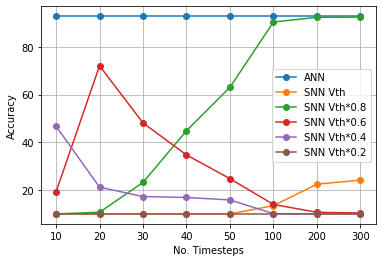

In [9]:
num_timesteps = [10, 20, 30, 40, 50, 100, 200, 300]

acc_list = []
scales = [1, 0.8, 0.6, 0.4, 0.2]
for scaling_factor in scales:
    _, acc_factor = timesteps_performance(snn_sr_model, test_loader, num_timesteps, scaling_factor)
    acc_list.append(acc_factor)

fig = plt.figure("Acc vs Timesteps")
plt.plot([ann_acc]*len(num_timesteps), "-o")
for k in range(len(scales)):
    plt.plot(acc_list[k], "-o")
plt.legend(["ANN", "SNN Vth", "SNN Vth*0.8", "SNN Vth*0.6", "SNN Vth*0.4", "SNN Vth*0.2"])
plt.xlabel("No. Timesteps")
plt.ylabel("Accuracy")
plt.xticks(range(8), [str(k) for k in num_timesteps])
plt.grid(True)
plt.show()

In [10]:
image_format = 'svg'  # e.g .png, .svg, etc.
image_name = 'vgg16_snn_sr_acc_timesteps.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

In [11]:
import numpy as np
np.save("acc_snn_vgg16_sr.npy", np.array(acc_list))


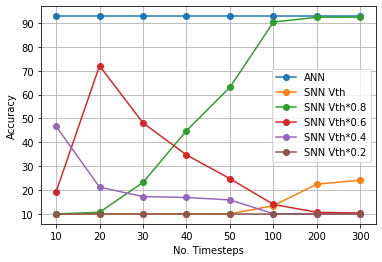

In [14]:
fig = plt.figure("Acc vs Timesteps")
plt.plot([ann_acc]*len(num_timesteps), "-o")
for k in range(len(scales)):
    plt.plot(acc_list[k], "-o")
plt.legend(["ANN", "SNN Vth", "SNN Vth*0.8", "SNN Vth*0.6", "SNN Vth*0.4", "SNN Vth*0.2"])
plt.xlabel("No. Timesteps")
plt.ylabel("Accuracy")
plt.xticks(range(8), [str(k) for k in num_timesteps])
plt.yticks([10,20,30,40,50,60,70,80,90], [10,20,30,40,50,60,70,80,90])
plt.grid(True)
plt.show()

In [15]:
image_format = 'svg'  # e.g .png, .svg, etc.
image_name = 'vgg16_snn_sr_acc_timesteps.svg'
fig.savefig(image_name, format=image_format, dpi=1200)